![MLU Logo](../../data/MLU_Logo.png)

# <a name="0">Responsible AI - Final Project Solution</a>

Build a fair [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) that predicts the __credit_risk__ field (whether some is a credit risk or not) of the [German Credit Dataset](https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29).

### Final Project Problem: Loan Approval

__Problem Definition:__
Given a set of features about an individual (e.g. age, past credit history, immigration status, ...) predict whether a loan is repaid or not (is customer a credit risk). We impose the additional constraint that the model should be fair with respect to different age groups ($\geq$ 25 yrs and $<$ 25 yrs).

In the banking industry, there are certain regulations regarding the use of sensitive features (e.g., age, ethnicity, marital status, ...). According to those regulations, it would not be okay if age played a significant role in the model (loans should be approved/denied regardless of an individuals' age).


``` 
F. Kamiran and T. Calders, "Data Preprocessing Techniques for Classification without Discrimination," Knowledge and Information Systems, 2012
```

1. <a href="#1">Read the datasets</a> (Given) 
2. <a href="#2">Data Processing</a> (Implement)
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a> (Suggested)
    * <a href="#23">Train - Validation - Test Datasets</a>
    * <a href="#24">Feature transformation</a>
3. <a href="#3">Train a Classifier on the Training Dataset</a> (Implement)
4. <a href="#4">Make Predictions on the Test Dataset</a> (Implement)
5. <a href="#5">Evaluate Results</a> (Given)


__Datasets and Files:__


- ```german_credit_training.csv```: Training data with loan applicants features, credit history, dependents, savings, account status, age group (and more). The label is __credit_risk__.

- ```german_credit_test.csv```: Test data with same features as above apart from label. This will be the data to make predictions for to emulate a production environment.

This notebook assumes an installation of the SageMaker kernel `conda_pytorch_p39`. In addition, libraries from a requirements.txt need to be installed:

In [1]:
!pip install --no-deps -U -q -r ../../requirements.txt

In [ ]:
%%capture

# Reshaping/basic libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# Fairness libraries
from folktables.acs import *
from folktables.folktables import *
from folktables.load_acs import *
from aif360.datasets import BinaryLabelDataset, Dataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover

# Operational libraries
import sys

sys.path.append("..")

# Jupyter(lab) libraries
import warnings

warnings.filterwarnings("ignore")

## 1. <a name="1">Read the datasets</a> (Given)
(<a href="#0">Go to top</a>)

Then, we read the __training__ and __test__ datasets into dataframes, using [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html). This library allows us to read and manipulate our data.

In [3]:
training_data = pd.read_csv("../../data/final_project/german_credit_training.csv")
test_data = pd.read_csv("../../data/final_project/german_credit_test.csv")

print("The shape of the training dataset is:", training_data.shape)
print("The shape of the test dataset is:", test_data.shape)

The shape of the training dataset is: (800, 24)
The shape of the test dataset is: (200, 23)


## 2. <a name="2">Data Processing</a> (Implement)
(<a href="#0">Go to top</a>) 

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the datasets.

In [4]:
training_data.head()

,ID,sex,personal_status,checking_account_status,credit_duration_months,credit_history,credit_purpose,credit_amount,savings,employed_since_years,...,age_years,other_installment_plans,housing,num_existing_credits,job_status,num_people_liable_for,telephone,foreign_worker,credit_risk,age_groups
0,564,male,married/widowed,... < 0 DM,24,existing credits paid back duly till now,retraining,4712,.. >= 1000 DM,1 <= ... < 4 years,...,37,bank,rent,2-3,management/self-employed/highly qualified empl...,0 to 2,True,False,0,1
1,484,male,married/widowed,... >= 200 DM,12,all credits at this bank paid back duly,others,1163,100 <= ... < 500 DM,1 <= ... < 4 years,...,44,none,rent,1,skilled employee/official,0 to 2,True,False,0,1
2,26,female,single,... >= 200 DM,6,delay in paying off in the past,furniture/equipment,426,unknown/no savings account,.. >= 7 years,...,39,none,rent,1,unskilled - resident,0 to 2,False,False,0,1
3,443,male,married/widowed,... >= 200 DM,12,no credits taken/all credits paid back duly,repairs,719,unknown/no savings account,.. >= 7 years,...,41,bank,rent,1,unskilled - resident,3 or more,False,False,1,1
4,211,female/male,female (non-single) or male (single),... >= 200 DM,36,no credits taken/all credits paid back duly,furniture/equipment,3835,.. >= 1000 DM,.. >= 7 years,...,45,none,rent,1,unskilled - resident,0 to 2,True,False,0,1


In [5]:
test_data.head()

,ID,sex,personal_status,checking_account_status,credit_duration_months,credit_history,credit_purpose,credit_amount,savings,employed_since_years,...,property,age_years,other_installment_plans,housing,num_existing_credits,job_status,num_people_liable_for,telephone,foreign_worker,age_groups
0,963,male,married/widowed,... >= 200 DM,24,no credits taken/all credits paid back duly,furniture/equipment,2397,100 <= ... < 500 DM,.. >= 7 years,...,building society savings agreement/life insurance,35,bank,rent,2-3,skilled employee/official,0 to 2,True,False,1
1,611,female/male,female (non-single) or male (single),0 <= ... < 200 DM,10,no credits taken/all credits paid back duly,others,1240,... < 100 DM,.. >= 7 years,...,real estate,48,none,own,1,unskilled - resident,3 or more,False,False,1
2,106,male,married/widowed,... >= 200 DM,18,critical account/other credits existing (not a...,others,6458,unknown/no savings account,.. >= 7 years,...,real estate,39,bank,rent,2-3,management/self-employed/highly qualified empl...,3 or more,True,False,1
3,891,male,married/widowed,... >= 200 DM,15,all credits at this bank paid back duly,furniture/equipment,1829,unknown/no savings account,.. >= 7 years,...,building society savings agreement/life insurance,46,none,rent,2-3,skilled employee/official,0 to 2,True,False,1
4,342,female,single,... < 0 DM,18,no credits taken/all credits paid back duly,furniture/equipment,3213,100 <= ... < 500 DM,... < 1 year,...,unknown/no property,25,none,for free,1,skilled employee/official,0 to 2,False,False,1


In [6]:
# Implement more EDA here

In [7]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        800 non-null    int64 
 1   sex                       800 non-null    object
 2   personal_status           800 non-null    object
 3   checking_account_status   800 non-null    object
 4   credit_duration_months    800 non-null    int64 
 5   credit_history            800 non-null    object
 6   credit_purpose            800 non-null    object
 7   credit_amount             800 non-null    int64 
 8   savings                   800 non-null    object
 9   employed_since_years      800 non-null    object
 10  installment_rate          800 non-null    object
 11  other_debtors_guarantors  800 non-null    object
 12  present_residence_since   800 non-null    object
 13  property                  800 non-null    object
 14  age_years                 

### 2.2 <a name="22">Select features to build the model</a> 
(<a href="#2">Go to Data Processing</a>)

Let's use all the features. Below you see a snippet of code that separates categorical and numerical columns based on their data type. This should only be used if we are sure that the data types are correctly assigned (check during EDA). Mindful with some of the feature names - they suggest numerical values but upon inspection it should become clear that they are actually categoricals (e.g. `employed_since_years` has been binned into groups).


In [8]:
# Grab model features/inputs and target/output
categorical_features = (
    training_data.drop("credit_risk", axis=1)
    .select_dtypes(include="object")
    .columns.tolist()
)
print("Categorical columns:", categorical_features)

print("")

numerical_features = (
    training_data.drop("credit_risk", axis=1)
    .select_dtypes(include=np.number)
    .columns.tolist()
)
print("Numerical columns:", numerical_features)

Categorical columns: ['sex', 'personal_status', 'checking_account_status', 'credit_history', 'credit_purpose', 'savings', 'employed_since_years', 'installment_rate', 'other_debtors_guarantors', 'present_residence_since', 'property', 'other_installment_plans', 'housing', 'num_existing_credits', 'job_status', 'num_people_liable_for']

Numerical columns: ['ID', 'credit_duration_months', 'credit_amount', 'age_years', 'age_groups']


We notice that `ID` is identified as numerical column. ID's should never be used as features for training as they are unique by row. Let's drop the ID from the model features after we have separated target and features:

In [9]:
model_target = "credit_risk"
model_features = categorical_features + numerical_features

print("Model features: ", model_features)
print("\n")
print("Model target: ", model_target)

Model features:  ['sex', 'personal_status', 'checking_account_status', 'credit_history', 'credit_purpose', 'savings', 'employed_since_years', 'installment_rate', 'other_debtors_guarantors', 'present_residence_since', 'property', 'other_installment_plans', 'housing', 'num_existing_credits', 'job_status', 'num_people_liable_for', 'ID', 'credit_duration_months', 'credit_amount', 'age_years', 'age_groups']


Model target:  credit_risk


In [10]:
to_remove = "ID"

# Drop 'ID' feature from the respective list(s)
if to_remove in model_features:
    model_features.remove(to_remove)
if to_remove in categorical_features:
    categorical_features.remove(to_remove)
if to_remove in numerical_features:
    numerical_features.remove(to_remove)

Let's also remove `age_years` as this is an obvious proxy for the age groups.

In [11]:
to_remove = "age_years"

# Drop 'ID' feature from the respective list(s)
if to_remove in model_features:
    model_features.remove(to_remove)
if to_remove in categorical_features:
    categorical_features.remove(to_remove)
if to_remove in numerical_features:
    numerical_features.remove(to_remove)

### 2.3 <a name="23">Train - Validation Datasets</a>
(<a href="#2">Go to Data Processing</a>)

We already have training and test datasets, but no validation dataset (which you need to create). Furthermore, the test dataset is missing the labels - the goal of the project is to predict these labels. 

To produce a validation set to evaluate model performance, split the training dataset into train and validation subsets using sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. 

In [12]:
# Implement here

In [13]:
# We only need to split between train and val (test is already separate)
train_data, val_data = train_test_split(
    training_data, test_size=0.1, shuffle=True, random_state=23
)

# Print the shapes of the Train - Test Datasets
print(
    "Train - Test - Validation datasets shapes: ",
    train_data.shape,
    test_data.shape,
    val_data.shape,
)

train_data.reset_index(inplace=True, drop=True)
val_data.reset_index(inplace=True, drop=True)

Train - Test - Validation datasets shapes:  (720, 24) (200, 23) (80, 24)


### 2.4 <a name="24">Feature transformation</a>
(<a href="#2">Go to Data Processing</a>)

Here, you have different options. You can use Reweighing, prepare for Disparate Impact Remover or use Suppression. Regardless of which method to use, it makes sense to prepare the data first by dealing with missing values, one-hot encoding and scaling.

In [14]:
### STEP 1 ###
##############

# Preprocess the numerical features
numerical_processor = Pipeline(
    [("num_imputer", SimpleImputer(strategy="mean")), ("num_scaler", MinMaxScaler())]
)
# Preprocess the categorical features
categorical_processor = Pipeline(
    [
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("cat_encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

### STEP 2 ###
##############

# Combine all data preprocessors from above
data_processor = ColumnTransformer(
    [
        ("numerical_processing", numerical_processor, numerical_features),
        ("categorical_processing", categorical_processor, categorical_features),
    ]
)

### STEP 3 ###
##############

# Fit the dataprocessor to our training data and apply transform to test data
processed_train = data_processor.fit_transform(train_data[model_features])
processed_test = data_processor.transform(test_data)

#### 2.4.1 DI-Transformation

The dataframe you just created will not have any column names for the one-hot encoded categorical features and will also be saved as sparse matrix. If you want to proceed with DI transformation, you need to convert the sparse matrix back to a data frame and also re-create the column names.

In [15]:
# Implement here

In [16]:
# Extract feature names from data processor (we need this as one-hot encoding creates new columns)
cat_ft_names = list(
    data_processor.transformers_[1][1]
    .named_steps["cat_encoder"]
    .get_feature_names_out(categorical_features)
)

# Convert the sparse matrix to a pandas dataframe and name columns
processed_train_df = pd.DataFrame.sparse.from_spmatrix(
    processed_train, columns=numerical_features + cat_ft_names
)

# Join label with the transformed dataset so we can pass it to AIF360
train_df = pd.concat([processed_train_df, train_data[model_target]], axis=1)

As final step for DI transformation you have to create a `BinaryLabelDataset` and also check the DI value of the dataset.

In [17]:
# Create a Dataset construct for AIF360
binaryLabelDataset_train = BinaryLabelDataset(
    df=train_df,
    label_names=["credit_risk"],
    protected_attribute_names=["age_groups"],
    favorable_label=0.0,
    unfavorable_label=1.0,
)

# Check pre-training bias
print(
    BinaryLabelDatasetMetric(
        binaryLabelDataset_train,
        unprivileged_groups=[{"age_groups": 0}],
        privileged_groups=[{"age_groups": 1}],
    ).disparate_impact()
)

0.8371212121212122


Now, use the AIF360 `DisparateImpactRemover`.

In [18]:
# Initialize DisparateImpactRemover
di_remover = DisparateImpactRemover(repair_level=0.5)

# Create transformed version (DI removed)
binaryLabelDataset_transform_train = di_remover.fit_transform(binaryLabelDataset_train)

# Convert back to dataframe
df_transform_train = binaryLabelDataset_transform_train.convert_to_dataframe()[0]

You can check that the transformation changed only the features, but not the labels by calculating the DI metric for the transformed dataset. The value will match what you had previously.

In [19]:
# Check pre-training bias for transformed dataset
print(
    BinaryLabelDatasetMetric(
        binaryLabelDataset_transform_train,
        unprivileged_groups=[{"age_groups": 0}],
        privileged_groups=[{"age_groups": 1}],
    ).disparate_impact()
)

0.8371212121212122


To visualize the transformation let's have a look at how the distribution of one of the numerical features changed.

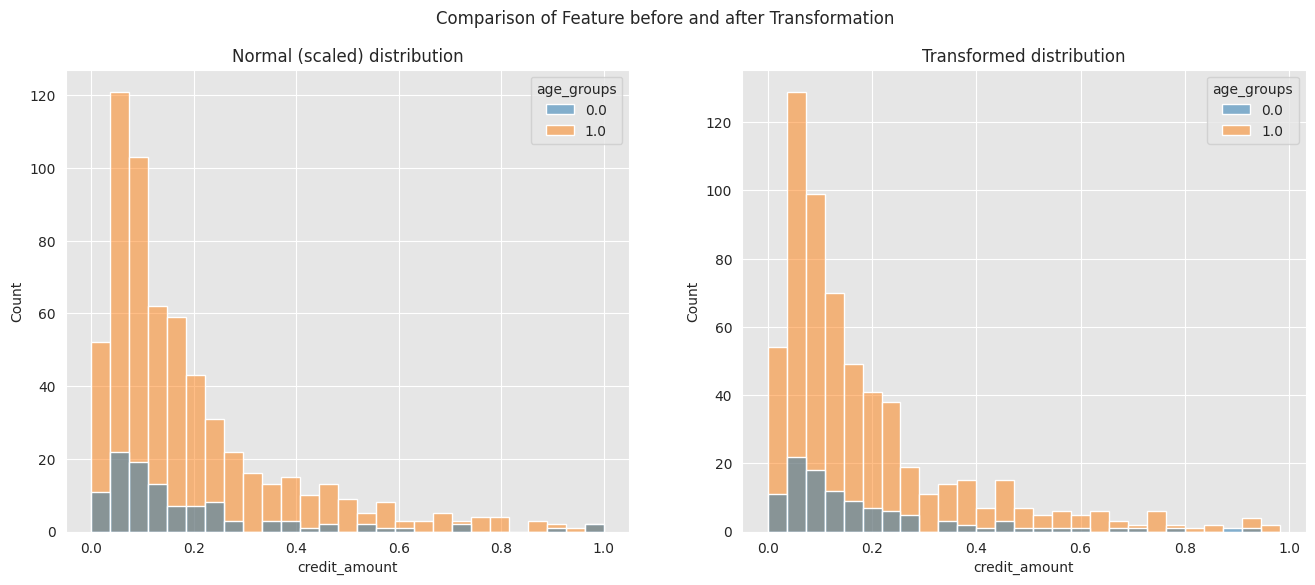

In [20]:
%matplotlib inline

# Initialize figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Set title of figure
fig.suptitle("Comparison of Feature before and after Transformation")

# Set title
ax1.title.set_text("Normal (scaled) distribution")
ax2.title.set_text("Transformed distribution")

# Create plots
sns.histplot(train_df, x="credit_amount", hue="age_groups", ax=ax1)
sns.histplot(df_transform_train, x="credit_amount", hue="age_groups", ax=ax2)
plt.show()

Finally, apply the DI transformation to the test data too. If you wanted to try different DI repair values, you could add a section before this one th at uses that validation dataset.

In [21]:
# Convert the sparse matrix to a pandas dataframe and name columns
processed_test_df = pd.DataFrame.sparse.from_spmatrix(
    processed_test, columns=numerical_features + cat_ft_names
)

# Repeat for test data
test_df = pd.concat(
    [
        processed_test_df,
        pd.read_csv("../../data/final_project/german_credit_test_labels.csv")[
            "credit_risk"
        ],
    ],
    axis=1,
)

# Create a Dataset construct for AIF360
binaryLabelDataset_test = BinaryLabelDataset(
    df=test_df,
    label_names=["credit_risk"],
    protected_attribute_names=["age_groups"],
    favorable_label=0.0,
    unfavorable_label=1.0,
)

# Create transformed version (DI removed)
binaryLabelDataset_transform_test = di_remover.fit_transform(binaryLabelDataset_test)

# Convert back to dataframe
df_transform_test = binaryLabelDataset_transform_test.convert_to_dataframe()[0].drop(
    "credit_risk", axis=1
)

#### 2.4.2 Reweighing

Alternatively if you want to build the model with reweighing, you can use the custom function below and then apply the weights during the training stage.

In [22]:
def reweighing(data, label, sensitive_attr, return_list=True):
    label_dict = dict()
    try:
        # This will loop through the different labels (1 - awarded grant, 0 - not awarded)
        for outcome in data[label].unique():
            weight_map = dict()
            # Check for all possible groups (here we have A & B but there could be more in reality)
            for val in data[sensitive_attr].unique():
                # Calculate the probabilities
                nom = (
                    len(data[data[sensitive_attr] == val])
                    / len(data)
                    * len(data[data[label] == outcome])
                    / len(data)
                )
                denom = len(
                    data[(data[sensitive_attr] == val) & (data[label] == outcome)]
                ) / len(data)
                # Store weights according to sensitive attribute
                weight_map[val] = round(nom / denom, 2)
            # Store
            label_dict[outcome] = weight_map
        # Create full list of all weights for every data point provided as input
        data["weights"] = list(
            map(lambda x, y: label_dict[y][x], data[sensitive_attr], data[label])
        )
        if return_list == True:
            return data["weights"].to_list()
        else:
            return label_dict
    except Exception as err:
        print(err)
        print("Dataframe might have no entries.")


reweigh_dict = reweighing(train_data, "credit_risk", "age_groups", False)

## 3. <a name="3">Train a Classifier</a> (Implement)
(<a href="#0">Go to top</a>)

Train the [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) pipeline.

In [23]:
# Implement here

In [24]:
# Training the model with re-weighting

# Get train data to train the classifier
X_train = processed_train_df.drop(["age_groups"], axis=1)
y_train = train_data[model_target]

# Fit the classifier to the train data
train_sample_weights = list(
    map(
        lambda x, y: reweigh_dict[y][x],
        train_df["age_groups"],
        train_df[model_target],
    )
)

# Initialize the LR
lr_rw = LogisticRegression(solver="liblinear")

# Make sure to add the sample weights
rw_model = lr_rw.fit(X_train, y_train.ravel(), sample_weight=train_sample_weights)

In [25]:
# Training the model with disparate impact remover

# Get train data to train the classifier
X_train_transform = df_transform_train.drop([model_target, "age_groups"], axis=1)
y_train = train_data[model_target]

# Initialize the LR
lr_di = LogisticRegression(solver="liblinear")

# Fit the classifier to the transformed data
di_model = lr_di.fit(X_train_transform, y_train.ravel())

## 4. <a name="4">Make Predictions on the Test Dataset</a> (Implement)
(<a href="#0">Go to top</a>)

Use the trained classifier to predict the labels on the test set. Below you will find a code snippet that evaluates for DI.

In [26]:
# Implement here

# Get test data to test the classifier
# ! test data should come from german_credit_test.csv !
# ...

# Use the trained model to make predictions on the test dataset
# test_predictions = ...

In [27]:
# Get test data to validate the classifier
X_test = processed_test_df.drop(["age_groups"], axis=1).copy(deep=True)
X_test_di = df_transform_test.drop(["age_groups"], axis=1).copy(deep=True)

# Use the fitted model to make predictions on the test dataset
test_predictions_rw = di_model.predict(X_test)

# Use the fitted model to make predictions on the test dataset
test_predictions_di = rw_model.predict(X_test_di)

Decide which prediction you want to evaluate and assign to `test_predictions`.

In [28]:
test_predictions = test_predictions_di

## 5. <a name="5">Evaluate Results</a> (Given)
(<a href="#0">Go to top</a>)

In [29]:
result_df = pd.DataFrame(columns=["ID", "credit_risk_pred"])
result_df["ID"] = test_data["ID"].tolist()
result_df["credit_risk_pred"] = test_predictions

result_df.to_csv("../../data/final_project/project_day2_result.csv", index=False)

### Final Evaluation on Test Data - Disparate Impact
To evaluate the fairness of the model predictions, we will calculate the disparate impact (DI) metric. For more details about DI you can have a look [here](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-post-training-bias-metric-di.html).

In [30]:
def calculate_di(test_data, pred_df, pred_col="credit_risk_pred"):
    """
    Function to calculate Disparate Impact metric using the results from this notebook.
    """
    try:
        # Merge predictions with original test data to model per group
        di_df = pred_df.merge(test_data, on="ID")
        # Count for group with members less than 25y old
        pos_outcomes_less25 = di_df[di_df["age_groups"] == 0][pred_col].value_counts()[
            0
        ]  # value_counts()[0] takes the count of the '0 credit risk' == 'not credit risk'
        total_less25 = len(di_df[di_df["age_groups"] == 0])
        # Count for group with members greater equal 25y old
        pos_outcomes_geq25 = di_df[di_df["age_groups"] == 1][pred_col].value_counts()[
            0
        ]  # value_counts()[0] takes the count of the '0 credit risk' == 'not credit risk'
        total_geq25 = len(di_df[di_df["age_groups"] == 1])
        # Check if correct number of gorups
        if total_geq25 == 0:
            print("There is only one group present in the data.")
        elif total_less25 == 0:
            print("There is only one group present in the data.")
        else:
            disparate_impact = (pos_outcomes_less25 / total_less25) / (
                pos_outcomes_geq25 / total_geq25
            )
            return disparate_impact
    except:
        print("Wrong inputs provided.")

In [31]:
calculate_di(test_data, result_df, "credit_risk_pred")

0.7338129496402878

### Final Evaluation on Test Data - Accuracy & F1 Score
In addition to fairness evaluation, we also need to check the general model performance. During the EDA stage we learned that the target distribution is skewed so we will use F1 score in addition to accuracy.

In [32]:
accuracy_score(
    pd.read_csv("../../data/final_project/german_credit_test_labels.csv")[
        "credit_risk"
    ],
    result_df["credit_risk_pred"],
)

0.785

In [33]:
f1_score(
    pd.read_csv("../../data/final_project/german_credit_test_labels.csv")[
        "credit_risk"
    ],
    result_df["credit_risk_pred"],
)

0.5825242718446603

This is the end of the notebook.